In [266]:
import diffusers
import torch
import random
from tqdm import tqdm

# pipe = diffusers.StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda", torch.float16)
pipe = diffusers.StableDiffusionPipeline.from_pretrained("Lykon/Dreamshaper").to("cuda", torch.float16)
pipe.scheduler = diffusers.EulerDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.safety_checker = None

In [302]:
# lets identify a latent direction by taking differences between opposites

mediums = [
    "painting",
    "drawing",
    "photograph",
    "HD photo",
    "illustration",
    "portrait",
    "sketch",
    "3d render",
    "digital painting",
    "concept art",
    "screenshot",
    "canvas painting",
    "watercolor art",
]

subjects = [
    "dog",
    "cat",
    "car",
    "building",
    "house",
    "tree",
    "flower",
    "mountain",
    "lake",
    "person",
    "man",
    "woman",
    "toy",
    "horse",
    "bird",
    "soup",
    "chicken",
    "fish",
    "fruit",

]

# target_word = "happy"
# opposite = "sad"

target_word = "tiger appearence"
opposite = "wolf appearence"

num = 300

with torch.no_grad():
    positives = []
    negatives = []
    for i in tqdm(range(num)):
        medium = random.choice(mediums)
        subject = random.choice(subjects)
        pos_prompt = f"a {medium} of a {target_word} {subject}"
        neg_prompt = f"a {medium} of a {opposite} {subject}"
        pos_toks = pipe.tokenizer(pos_prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=77).input_ids.cuda()
        neg_toks = pipe.tokenizer(neg_prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=77).input_ids.cuda()
        pos = pipe.text_encoder(pos_toks).pooler_output
        neg = pipe.text_encoder(neg_toks).pooler_output
        positives.append(pos)
        negatives.append(neg)

100%|██████████| 300/300 [00:04<00:00, 66.17it/s]


In [305]:
positives = torch.cat(positives, dim=0)
negatives = torch.cat(negatives, dim=0)

diffs = positives - negatives

avg_diff = diffs.mean(0, keepdim=True)

In [206]:
def run_direction(prompt = "a photo of a house",
                scale = 2,
                seed = 15,
                only_pooler = False,
                correlation_weight_factor = 1.0,
                **pipeline_kwargs
                ):
    # if doing full sequence, [-0.3,0.3] work well, higher if correlation weighted is true
    # if pooler token only [-4,4] work well

    with torch.no_grad():
        toks = pipe.tokenizer(prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=77).input_ids.cuda()
        prompt_embeds = pipe.text_encoder(toks).last_hidden_state

        if only_pooler:
            prompt_embeds[:,toks.argmax()] = prompt_embeds[:,toks.argmax()] + avg_diff * scale
        else:
            normed_prompt_embeds = prompt_embeds / prompt_embeds.norm(dim=-1, keepdim=True)
            sims = normed_prompt_embeds[0] @ normed_prompt_embeds[0].T
            weights = sims[toks.argmax(), :][None,:,None].repeat(1,1,768)

            standard_weights = torch.ones_like(weights)

            weights = standard_weights + (weights - standard_weights) * correlation_weight_factor

            # weights = torch.sigmoid((weights-0.5)*7)

            prompt_embeds = prompt_embeds + (weights * avg_diff[None,:].repeat(1,77,1) * scale)

        torch.manual_seed(seed)
        image = pipe(prompt_embeds=prompt_embeds, **pipeline_kwargs).images

    return image

image = run_direction("a photo of a house", scale=2, seed=16, height=640, width=640, num_inference_steps=25)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:01<00:00, 18.57it/s]


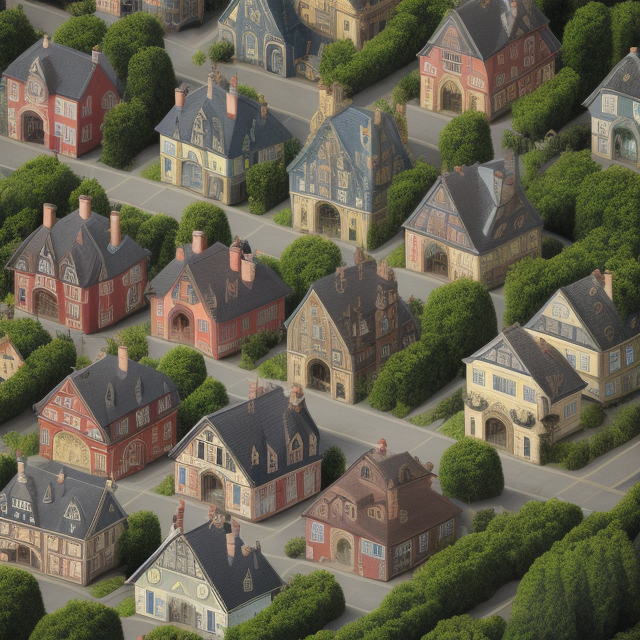

In [207]:
image[0]

In [316]:
from PIL import Image
def spectrum(prompt = "a photo of a house",
            low_scale=-2,
            high_scale=2,
            steps=5,
            seed = 15,
            only_pooler = False,
            correlation_weight_factor = 1.0,
            **pipeline_kwargs
            ):
    
    images = []
    for i in range(steps):
        scale = low_scale + (high_scale - low_scale) * i / (steps-1)
        image = run_direction(prompt, scale, seed, only_pooler, correlation_weight_factor, **pipeline_kwargs)
        images.append(image[0])

    canvas = Image.new('RGB', (640*steps, 640))
    for i, im in enumerate(images):
        canvas.paste(im, (640*i, 0))
    
    return canvas

scale = 0.8
comparisson = spectrum("a photo of a person", low_scale=-scale, high_scale=scale, steps=5, seed=22, 
                        only_pooler=False, correlation_weight_factor=0.7, height=640, width=640, num_inference_steps=25)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:01<00:00, 18.58it/s]


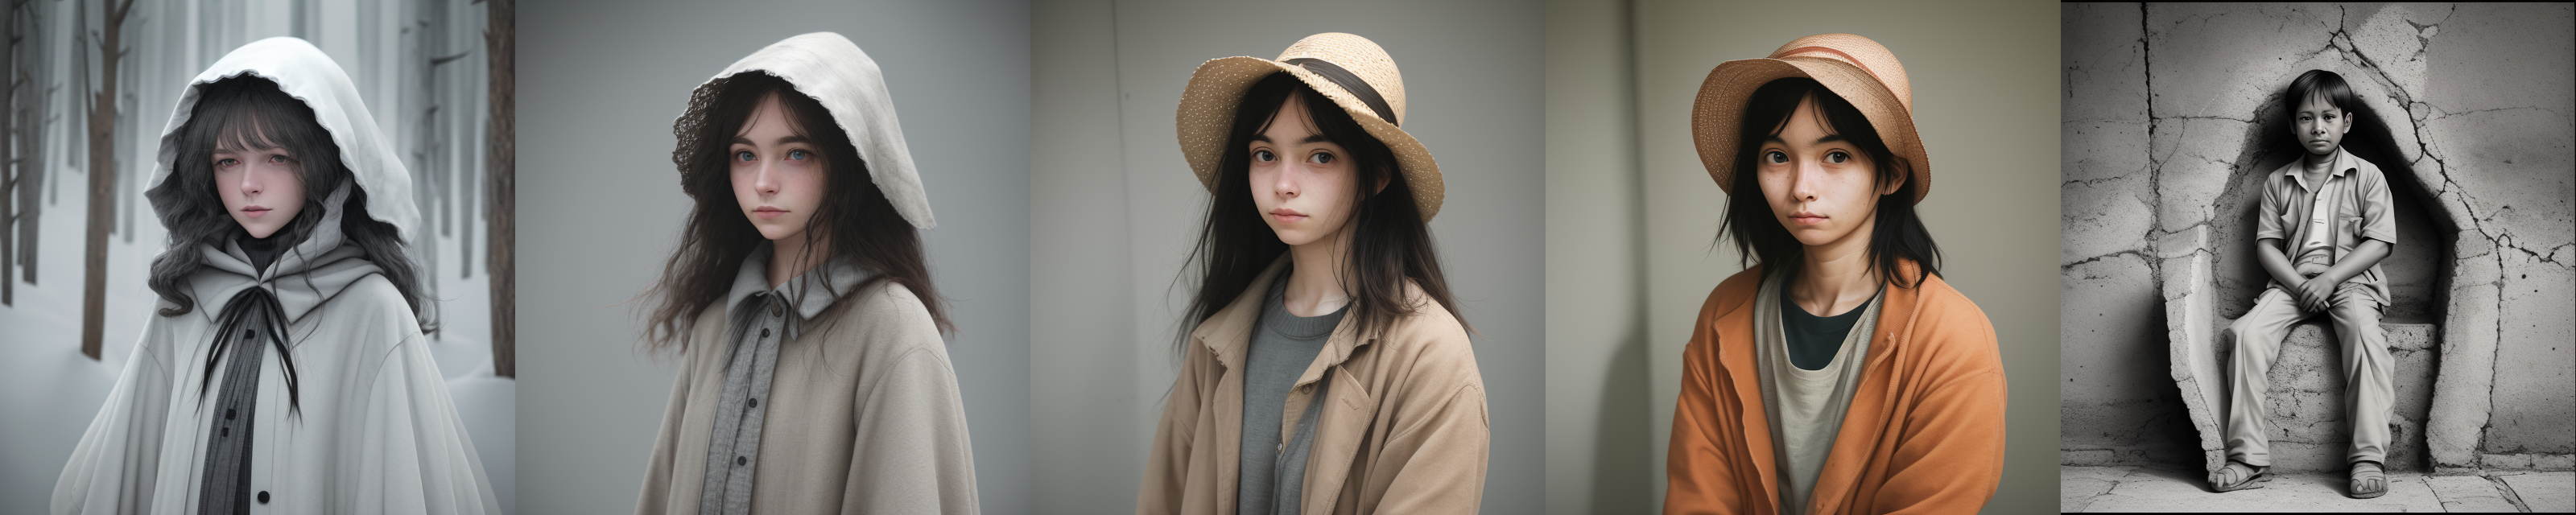

In [317]:
comparisson

In [32]:
# we can also try doing this in CLIPs input space/embedding table
# although this might be trickier if your two phrases are a different number of tokens
pos_phrase = "old"
neg_phrase = "young"

pos_toks = pipe.tokenizer(pos_phrase, return_tensors="pt", padding="longest", truncation=True, add_special_tokens=False).input_ids.cuda()
neg_toks = pipe.tokenizer(neg_phrase, return_tensors="pt", padding="longest", truncation=True, add_special_tokens=False).input_ids.cuda()

with torch.no_grad():
    pos_emb = pipe.text_encoder.text_model.embeddings(pos_toks)
    neg_emb = pipe.text_encoder.text_model.embeddings(neg_toks)
    diff = (pos_emb - neg_emb).squeeze(0)

In [68]:
from transformers.modeling_attn_mask_utils import _create_4d_causal_attention_mask

# this one doesnt seem to work as well
# -0.01, 0.01 if only_pooler
# -10, 10 if full sequence

prompt = "a portrait of a man"
scale = -0.01
scale = 10
seed = 11
only_pooler = True

toks = pipe.tokenizer(prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=77).input_ids.cuda()
embedded = pipe.text_encoder.text_model.embeddings(toks)

if only_pooler:
    embedded[:,toks.argmax()] = embedded[:,toks.argmax()] + diff * scale
else:
    embedded = embedded + avg_diff.unsqueeze(0) * scale

causal_attention_mask = _create_4d_causal_attention_mask(
    toks.shape, embedded.dtype, device=embedded.device
)

encoder_outputs = pipe.text_encoder.text_model.encoder(
            inputs_embeds=embedded,
            attention_mask=None,
            causal_attention_mask=causal_attention_mask,
            output_attentions=False,
            output_hidden_states=False,
            return_dict=False,
        )

last_hidden_state = encoder_outputs[0]
last_hidden_state = pipe.text_encoder.text_model.final_layer_norm(last_hidden_state)

torch.manual_seed(seed)
image = pipe(prompt_embeds=last_hidden_state, height=640, width=640).images

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 17.27it/s]


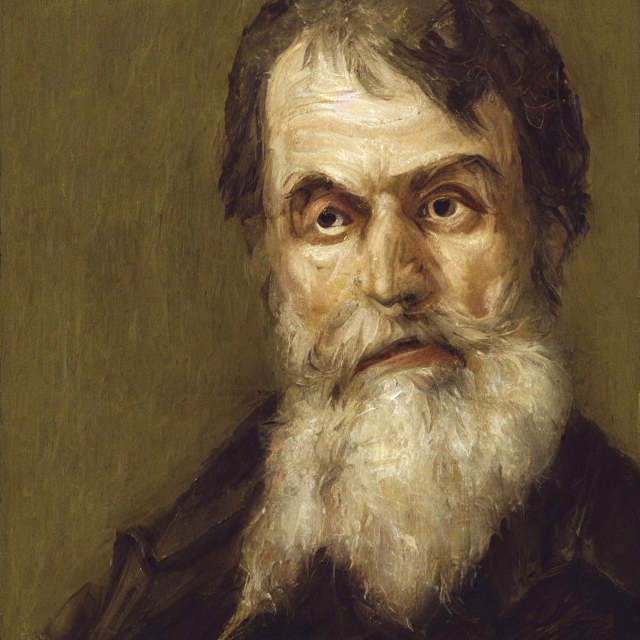

: 

In [69]:
image[0]

In [ ]:
# this method here is like a better version of the above, 
# by using gradient descent we can still work in input space but project back onto manifold
# https://github.com/ethansmith2000/SGDImagePrompt